<a href="https://colab.research.google.com/github/jgraving/deepposekit/blob/master/examples/step5b_predict_new_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# DeepPoseKit Step 5b - Predict on a dataset

This is step 5b of the example notebooks for using DeepPoseKit. This notebook shows you how to use your trained model to predict on new data.

If you haven't already installed DeepPoseKit and downloaded the example datasets you can run the next cell

In [2]:
!git clone https://github.com/jgraving/deepposekit-data

import sys
!{sys.executable} -m pip install \
git+https://github.com/jgraving/deepposekit \
git+https://github.com/jgraving/deepposekit-annotator

fatal: destination path 'deepposekit-data' already exists and is not an empty directory.
  Cloning https://github.com/jgraving/deepposekit-annotator to /private/var/folders/st/hhx75tj167g4qfsmb3rt8r7r0000gn/T/pip-req-build-qb_bcbr0
  Running command git clone -q https://github.com/jgraving/deepposekit-annotator /private/var/folders/st/hhx75tj167g4qfsmb3rt8r7r0000gn/T/pip-req-build-qb_bcbr0
  Cloning https://github.com/jgraving/deepposekit-annotator to /private/var/folders/st/hhx75tj167g4qfsmb3rt8r7r0000gn/T/pip-req-build-mg9cafcg
  Running command git clone -q https://github.com/jgraving/deepposekit-annotator /private/var/folders/st/hhx75tj167g4qfsmb3rt8r7r0000gn/T/pip-req-build-mg9cafcg
  Stored in directory: /private/var/folders/st/hhx75tj167g4qfsmb3rt8r7r0000gn/T/pip-ephem-wheel-cache-xzd525ew/wheels/0f/71/5b/0476551ba44d5d4e74da628c5bffdc210d6091bcd9a002e022
Successfully built dpk-annotator


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob

from deepposekit.models import load_model
from deepposekit import VideoReader, VideoWriter, TrainingGenerator

import tqdm
import time
from os.path import expanduser
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

HOME = expanduser("~") if not IN_COLAB else '.'

Using TensorFlow backend.
/home/jake/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jake/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jake/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jake/.local/lib/python3.6/site-packages/tensorflow/python/framewo

In [2]:
models = sorted(glob.glob(HOME + '/deepposekit-data/datasets/fly/*model*.h5'))
models

['/home/jake/deepposekit-data/datasets/fly/best_model_densenet.h5',
 '/home/jake/deepposekit-data/datasets/fly/best_model_fly_densenet.h5']

# Load the trained model

This loads the trained model into memory for making predictions

In [3]:
model = load_model(models[0])

/home/jake/.local/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [4]:
videos = sorted(glob.glob(HOME + '/deepposekit-data/datasets/fly/*video.avi'))
videos

['/home/jake/deepposekit-data/datasets/fly/video.avi']

# Test the video

Check to make sure `VideoReader` is correctly loading the video frames

In [7]:
reader = VideoReader(videos[0], batch_size=10, gray=True)
frames = reader[0]
reader.close()

True

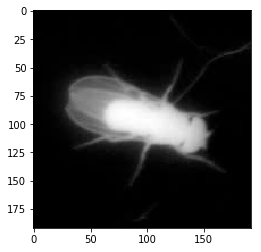

In [8]:
plt.imshow(frames[0,...,0], cmap='gray')
plt.show()

# Makes predictions for the full video

This loads batches of frames and makes predictions


In [9]:
reader = VideoReader(videos[0], batch_size=100, gray=True)
predictions = model.predict_generator(reader, steps=len(reader), verbose=1)
reader.close()

338/338 [==============================] - 59s 176ms/step


True

This splits the predictions into their row coordinates (y-axis), column coordinates (x-axis), and confidence scores from each confidence map.

In [9]:
row, col, confidence = np.split(predictions, 3, -1)

Plot the confidence scores

In [ ]:
plt.hist(confidence.flatten(), bins=100)
plt.show()

# Save the data

Once you have your predictions you can save it however you wish. Here is an example using numpy.save

In [10]:
np.save(HOME + '/deepposekit-data/datasets/fly/predictions.npy', predictions)

# Visualize the data

This is an example of how to visualize the predicted posture data on the original video.

In [11]:
annotations = sorted(glob.glob(HOME + '/deepposekit-data/datasets/fly/*annotation*.h5'))
train_generator = TrainingGenerator(annotations[0])

predictions = predictions[...,:2]
predictions *= (160./192.)
predictions *= 3

/home/jake/.local/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [18]:
# TODO: Turn this into a function
cmap = plt.cm.hsv(np.linspace(0, 1, train_generator.n_keypoints))[:, :3][:, ::-1] * 255

writer = VideoWriter(HOME + '/fly_posture.mp4', 'MP4V', 30.0, (160*3,160*3))
reader = VideoReader(videos[0], batch_size=1, gray=True)

for frame, coords in tqdm.tqdm(zip(reader, predictions)):
    frame = frame[0]
    frame = frame.copy()
    frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    frame = cv2.resize(frame, (160*3, 160*3))
    frame = cv2.bitwise_not(frame)
    original_frame = frame.copy()
    for idx, node in enumerate(train_generator.graph):
        if node >= 0:
            pt1 = coords[idx]
            pt2 = coords[node]
            cv2.line(frame, (pt1[0], pt1[1]), (pt2[0], pt2[1]), (0,0,255), 2, cv2.LINE_AA)
    for idx, coord in enumerate(coords):
        coord = coord.astype(int)
        cv2.circle(frame, (coord[0], coord[1]), 5, tuple(cmap[idx]), -1, lineType=cv2.LINE_AA)
        
    writer.write(frame)

writer.close()
reader.close()

33749it [01:31, 367.99it/s]


True

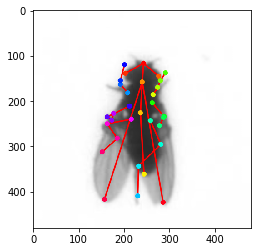

In [19]:
plt.imshow(frame[...,::-1])
plt.show()

In [ ]:
# TODO: Add code for selecting and merging new data